## Load MNIST Dataset
### MNIST Dataset was loaded from Tensorflow package from -- https://www.tensorflow.org/datasets/catalog/mnist
Load the MNIST dataset is downloaded using the tensor flow package, with information in the link above. The link given in the assignment is now password protected, so I pulled it directly from the TensorFlow package instead.

In [30]:
import tensorflow as tf
import numpy as np
import math;
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.datasets import mnist

NUM_CLASSES = 10
DROPOUT_RATE = 0.5
EPOCHS = 1
INPUT_SHAPE = (28, 28)
BATCH_SIZE = 600

def get_mnist_dataset_normalized():
    """
    Loads the MNIST dataset and normalizes the pixel values to [0, 1]. Also one-hot encodes the labels so it's usable with the training models
    :return: x_train, y_train, x_test, y_test
    """
    num_label_classes = 10  # Number of classes in MNIST, (0-9 digits)
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalize pixel values to [0, 1]
    x_train,x_test = x_train.astype('float32'), x_test.astype('float32') 
    # One-hot encode the labels
    y_train,y_test = tf.one_hot(y_train, depth=NUM_CLASSES), tf.one_hot(y_test, depth=NUM_CLASSES)
    return x_train, y_train, x_test, y_test


## Soft-max Regression Classifier
This section will define method to use the soft-max regression classifier to classify the MNIST dataset.
The classifier will have optional parameters to use or not use dropout, and to use or not use batch normalization.
 #### Parameters
 * Learning Rate: 0.1
 * Batch Size: 100
 * Dropout Rate (when applied): 0.3
 * Training Iterations over the data: 10

In [31]:
class SoftmaxRegressionClassifier:
    def __init__(self, x_train, y_train, x_test, y_test, dropout=False, batch_norm=False):
        self.x_train, self.y_train, self.x_test, self.y_test = x_train, y_train, x_test, y_test
        self.output_size = 10
        self.learning_rate = 0.01
        self.input_size = 28 * 28
        self.track_every_x_steps = 10
        # Weights
        self.weights = tf.Variable(tf.random.normal([self.input_size, self.output_size], dtype=tf.float32))
        self.biases = tf.Variable(tf.zeros([self.output_size], dtype=tf.float32))

        # Variable to modify the algorithm
        self.use_dropout = dropout
        self.use_batch_normalization = batch_norm
        # data to keep track of for graphing
        self.train_accuracy_data = []
        self.train_loss_data = []
        self.test_accuracy_data = []
    
    def train(self, batch_size=BATCH_SIZE):
        model = Sequential()
        model.add(Flatten(input_shape=INPUT_SHAPE) )  # Flatten the 28x28 input images

        # Optionally add batch normalization
        if self.use_batch_normalization:
            model.add(BatchNormalization())

        # Output layer
        model.add(Dense(NUM_CLASSES, activation='softmax'))

        # Optionally add dropout
        if self.use_dropout:
            model.add(Dropout(DROPOUT_RATE))

        model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

        step = 0
        for epoch in range(EPOCHS):
            for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train)).batch(batch_size):
                
                with tf.GradientTape() as tape:
                    y_pred = model(x_batch)
                    loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred))
                
                grads = tape.gradient(loss_value, model.trainable_weights)
                model.optimizer.apply_gradients(zip(grads, model.trainable_weights))

                if step % self.track_every_x_steps == 0:
                    accuracy_value = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(y_batch, y_pred))

                    # Evaluate accuracy and loss for each step for the training data
                    self.train_accuracy_data.append(accuracy_value)
                    self.train_loss_data.append(loss_value)
                    # Evaluate the accuracy on the test data at every step
                    _, external_accuracy = model.evaluate(self.x_test, self.y_test, verbose=0)
                    self.test_accuracy_data.append(external_accuracy)
                step += 1

    
    def get_train_data(self):
        return self.train_accuracy_data, self.train_loss_data

    def get_data_x_values(self):
        return list(range(0, len(self.train_accuracy_data)*self.track_every_x_steps, self.track_every_x_steps))

    def get_test_data_accuracy(self):
        return self.test_accuracy_data


In [32]:
x_train, y_train, x_test, y_test = get_mnist_dataset_normalized()

softmax = SoftmaxRegressionClassifier(x_train, y_train, x_test, y_test, False, False)
softmax.train()
softmax_train_accuracy_x_axis = softmax.get_data_x_values()
softmax_train_accuracy, softmax_loss_data = softmax.get_train_data()

softmax_dropout = SoftmaxRegressionClassifier(x_train, y_train, x_test, y_test, True, False)
softmax_dropout.train()
softmax_dropout_train_accuracy, softmax_dropout_loss_data = softmax_dropout.get_train_data()

softmax_batch_norm = SoftmaxRegressionClassifier(x_train, y_train, x_test, y_test, False, True)
softmax_batch_norm.train()
softmax_batch_norm_train_accuracy, softmax_batch_norm_loss_data = softmax_batch_norm.get_train_data()

#### Graph Accuracy and Loss for the Softmax Comparisons with the following conditions:
1. Without any additional aglorithms
2. With dropout
3. With batch normalization

In [33]:

def plot_training_loss_data(figure, x_values, loss_data, loss_data_with_dropout, loss_data_with_batch_norm, title, classifier_type, figure_rows, figure_columns, plot_position):
    subplot = figure.add_subplot(figure_rows, figure_columns, plot_position)
    subplot.plot(x_values, loss_data, label=f"{classifier_type}")
    subplot.plot(x_values, loss_data_with_dropout, label=f"{classifier_type} with Dropout")
    subplot.plot(x_values, loss_data_with_batch_norm, label=f"{classifier_type} with Batch Normalization")
    subplot.set_xlabel('Training Steps')
    subplot.set_ylabel('Training Loss')
    subplot.set_title(title)
    subplot.legend()
    return subplot

def plot_training_accuracy_data(figure, x_values, accuracy_data, accuracy_data_with_dropout, accuracy_data_with_batch_norm, title, classifier_type, figure_rows, figure_columns, plot_position):
    subplot = figure.add_subplot(figure_rows,figure_columns, plot_position)
    subplot.plot(x_values, accuracy_data, label=f"{classifier_type}")
    subplot.plot(x_values, accuracy_data_with_dropout, label=f"{classifier_type} with Dropout")
    subplot.plot(x_values, accuracy_data_with_batch_norm, label=f"{classifier_type} with Batch Normalization")
    subplot.set_xlabel('Training Steps')
    subplot.set_ylabel('Accuracy')
    subplot.set_title(title)
    subplot.legend()
    return subplot

def plot_test_accuracy_data(figure, x_values, accuracy_data, accuracy_data_with_dropout, accuracy_data_with_batch_norm, title, classifier_type, figure_rows, figure_columns, plot_position):
    subplot = figure.add_subplot(figure_rows,figure_columns,plot_position)
    subplot.plot(x_values, accuracy_data, label=f"{classifier_type}")
    subplot.plot(x_values, accuracy_data_with_dropout, label=f"{classifier_type} with Dropout")
    subplot.plot(x_values, accuracy_data_with_batch_norm, label=f"{classifier_type} with Batch Normalization")
    subplot.set_xlabel('Training Steps')
    subplot.set_ylabel('Accuracy')
    subplot.set_title(title)
    subplot.legend()
    return subplot

def compare_classifiers(figure, x_values, data_softmax, data_mlp, data_cnn, title, y_label, figure_rows, figure_columns, plot_position):
    subplot = figure.add_subplot(figure_rows,figure_columns,plot_position)
    subplot.plot(x_values, data_softmax, label=f"Softmax")
    subplot.plot(x_values, data_mlp, label=f"MPL")
    subplot.plot(x_values, data_cnn, label=f"CNN")
    subplot.set_xlabel('Training Steps')
    subplot.set_ylabel('Accuracy')
    subplot.set_title(title)
    subplot.legend()
    return subplot

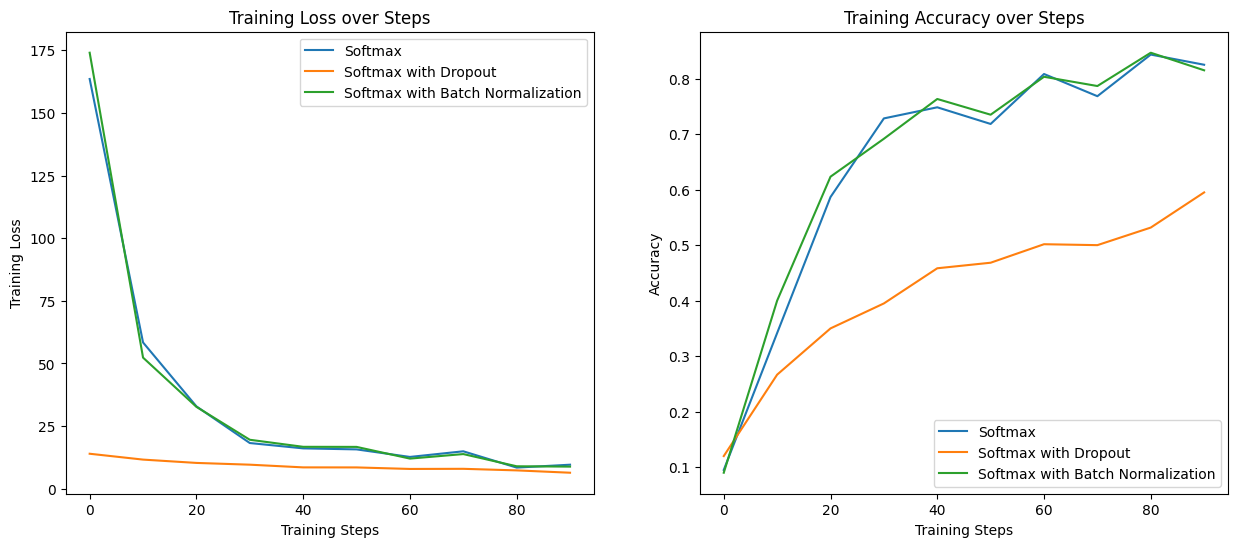

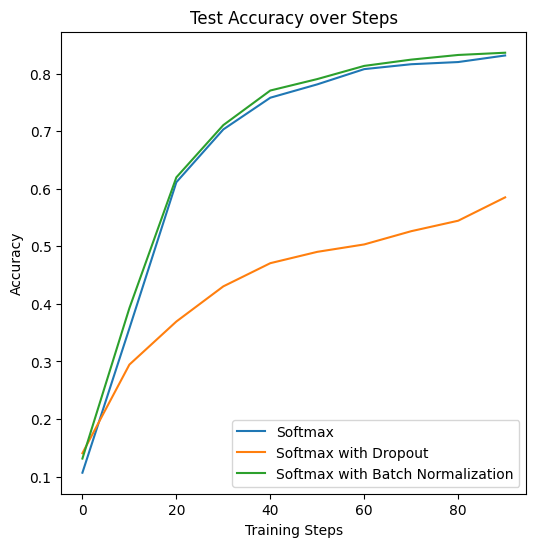

In [34]:
# Plot training loss and accuracy for MLP, MLP with dropout, and MLP with batch normalization
figure1 = plt.figure(figsize=(15, 6))
subplot1 = plot_training_loss_data(figure1, softmax_train_accuracy_x_axis, softmax_loss_data, softmax_dropout_loss_data, softmax_batch_norm_loss_data, 'Training Loss over Steps', "Softmax", 1, 2, 1)
figure1.add_subplot(subplot1)
subplot2 = plot_training_accuracy_data(figure1, softmax_train_accuracy_x_axis, softmax_train_accuracy, softmax_dropout_train_accuracy, softmax_batch_norm_train_accuracy, 'Training Accuracy over Steps', "Softmax", 1, 2, 2)
figure1.add_subplot(subplot2)
plt.show()

figure2 = plt.figure(figsize=(6, 6))
subplot3 = plot_test_accuracy_data(figure2, softmax_train_accuracy_x_axis, softmax.get_test_data_accuracy(), softmax_dropout.get_test_data_accuracy(), softmax_batch_norm.get_test_data_accuracy(), 'Test Accuracy over Steps', "Softmax", 1, 1, 1)
figure2.add_subplot(subplot3)
plt.show()

# MLP

In [35]:
class MultiLayerPerception():
    def __init__(self, x_data, y_data, x_test, y_test, use_dropout=False, use_batch_norm=False):
        self.x_train, self.y_train, self.x_test, self.y_test = x_train, y_train, x_test, y_test
        self.use_dropout, self.use_batch_norm = use_dropout, use_batch_norm
        self.mlp_model = self.create_model()
        self.steps = 0
        # Create lists to store loss and accuracy
        self.track_every_x_steps = 10
        self.loss_history = []
        self.accuracy_history = []
        self.accuracy_test_data = []

    def create_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=INPUT_SHAPE))  # Flatten the 28x28 input images

        # First hidden layer
        model.add(Dense(128, activation='relu'))
        if self.use_batch_norm:
            model.add(BatchNormalization())
        if self.use_dropout:
            model.add(Dropout(DROPOUT_RATE))

        # Second hidden layer
        model.add(Dense(64, activation='relu'))
        if self.use_batch_norm:
            model.add(BatchNormalization())
        if self.use_dropout:
            model.add(Dropout(DROPOUT_RATE))

        # Output layer
        model.add(Dense(10, activation='softmax'))
        return model

    def train(self, batch_size=BATCH_SIZE):
        self.mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        # Training loop
        for epoch in range(EPOCHS):
            for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size):
                with tf.GradientTape() as tape:
                    y_pred = self.mlp_model(x_batch)
                    loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred))
                
                grads = tape.gradient(loss_value, self.mlp_model.trainable_weights)
                self.mlp_model.optimizer.apply_gradients(zip(grads, self.mlp_model.trainable_weights))
                
                # Evaluate accuracy and loss for every configuarable number of step for the training data
                if self.steps % self.track_every_x_steps == 0:
                    accuracy_value = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(y_batch, y_pred))
                    self.loss_history.append(loss_value)
                    self.accuracy_history.append(accuracy_value)
                    _, external_accuracy = self.mlp_model.evaluate(self.x_test, self.y_test, verbose=0)
                    self.accuracy_test_data.append(external_accuracy)

                self.steps += 1

    def get_train_data(self):
        return self.accuracy_history, self.loss_history

    def get_train_data_x_array(self):
        return list(range(0, len(self.loss_history)*self.track_every_x_steps, self.track_every_x_steps))

    def get_test_data_accuracy(self):
        return self.accuracy_test_data
        


In [36]:
x_train, y_train, x_test, y_test = get_mnist_dataset_normalized()

# Standard MLP
mlp = MultiLayerPerception(x_train, y_train, x_test, y_test, False, False)
mlp.train()
mlp_train_accuracy, mlp_loss_data = mlp.get_train_data()
mlp_train_accuracy_x_axis = mlp.get_train_data_x_array()
mlp_test_accuracy = mlp.get_test_data_accuracy()

# MLP with dropout
mlp_dropout = MultiLayerPerception(x_train, y_train, x_test, y_test, True, False)
mlp_dropout.train()
mlp_dropout_train_accuracy, mlp_dropout_loss_data = mlp_dropout.get_train_data()
mlp_dropout_test_accuracy = mlp_dropout.get_test_data_accuracy()

# MLP with batch normalization
mlp_batch_norm = MultiLayerPerception(x_train, y_train, x_test, y_test, False, True)
mlp_batch_norm.train()
mlp_batch_norm_train_accuracy, mlp_batch_norm_loss_data = mlp_batch_norm.get_train_data()
mlp_batch_norm_test_accuracy = mlp_batch_norm.get_test_data_accuracy()


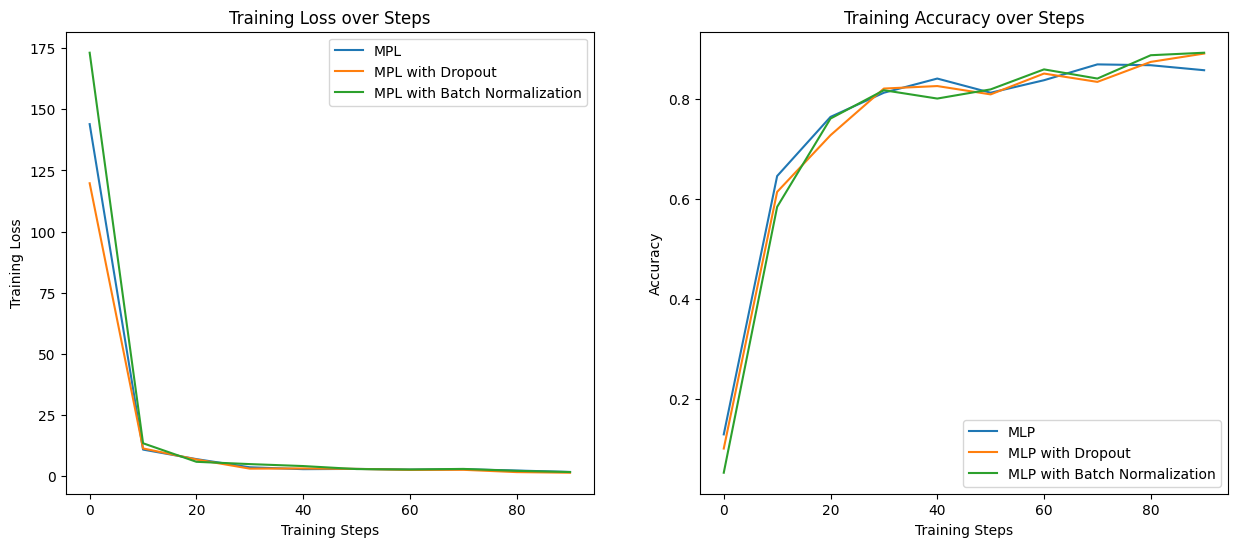

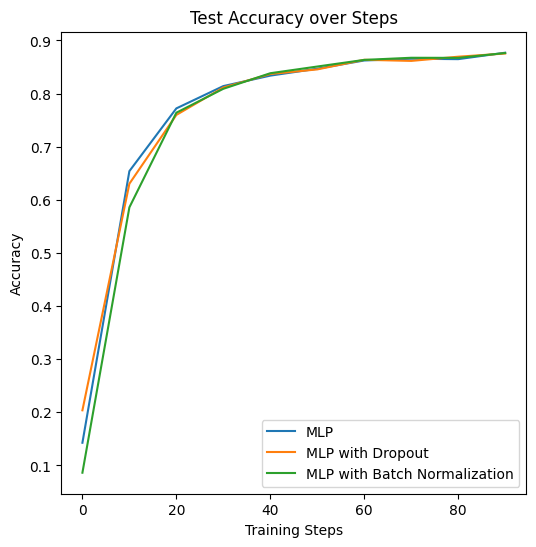

In [37]:
# Plot training loss and accuracy for MLP, MLP with dropout, and MLP with batch normalization
figure3 = plt.figure(figsize=(15, 6))
subplot = plot_training_loss_data(figure3, mlp_train_accuracy_x_axis, mlp_loss_data, mlp_dropout_loss_data, mlp_batch_norm_loss_data, 'Training Loss over Steps', "MPL", 1, 2, 1)
figure3.add_subplot(subplot)
subplot = plot_training_accuracy_data(figure3, mlp_train_accuracy_x_axis, mlp_train_accuracy, mlp_dropout_train_accuracy, mlp_batch_norm_train_accuracy, 'Training Accuracy over Steps', "MLP", 1, 2, 2)
figure3.add_subplot(subplot)
plt.show()

figure4 = plt.figure(figsize=(6, 6))
subplot = plot_test_accuracy_data(figure4, mlp_train_accuracy_x_axis, mlp_test_accuracy, mlp_dropout_test_accuracy, mlp_batch_norm_test_accuracy, 'Test Accuracy over Steps', "MLP", 1, 1, 1)
figure4.add_subplot(subplot)

plt.show()


# CNN

In [38]:
class CNN():
    def __init__(self, x_train, y_train, x_test, y_test, use_dropout=False, use_batch_norm=False):
        self.x_train, self.y_train, self.x_test, self.y_test = x_train, y_train, x_test, y_test
        self.use_dropout, self.use_batch_norm = use_dropout, use_batch_norm
        self.steps = 0
        # Create lists to store loss and accuracy
        self.track_every_x_steps = 10
        self.loss_history = []
        self.accuracy_history = []
        self.accuracy_test_data = []
    
    def create_model(self):
        # Define the CNN architecture
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
        if self.use_batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        if self.use_batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        if self.use_dropout:
            model.add(Dropout(DROPOUT_RATE))
        model.add(Dense(10, activation='softmax'))
        return model

    def train(self, batch_size=BATCH_SIZE):
        # Compile the model
        model = self.create_model()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        step = 0
        # Training loop
        for epoch in range(EPOCHS):
            for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size):
                with tf.GradientTape() as tape:
                    y_pred = model(x_batch)
                    loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred))
                
                grads = tape.gradient(loss_value, model.trainable_weights)
                model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                
                # Evaluate accuracy and loss for every configuarable number of step for the training data
                if step % self.track_every_x_steps == 0:
                    accuracy_value = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(y_batch, y_pred))
                    self.loss_history.append(loss_value)
                    self.accuracy_history.append(accuracy_value)
                    _, external_accuracy = model.evaluate(self.x_test, self.y_test, verbose=0)
                    self.accuracy_test_data.append(external_accuracy)
                step += 1

    def get_train_data(self):
        return self.accuracy_history, self.loss_history

    def get_train_data_x_array(self):
        return list(range(0, len(self.loss_history)*self.track_every_x_steps, self.track_every_x_steps))

    def get_test_data_accuracy(self):
        return self.accuracy_test_data

In [39]:
x_train, y_train, x_test, y_test = get_mnist_dataset_normalized()

# Expand dimensions for compatibility with CNN
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Standard MLP
cnn = CNN(x_train, y_train, x_test, y_test, False, False)
cnn.train()
cnn_train_accuracy_x_axis = cnn.get_train_data_x_array()
cnn_train_accuracy, cnn_loss_data = cnn.get_train_data()
cnn_test_accuracy = cnn.get_test_data_accuracy()

# MLP with dropout
cnn_dropout = CNN(x_train, y_train, x_test, y_test, True, False)
cnn_dropout.train()
cnn_dropout_train_accuracy, cnn_dropout_loss_data = cnn_dropout.get_train_data()
cnn_dropout_test_accuracy =cnn_dropout.get_test_data_accuracy()

# MLP with batch normalization
cnn_batch_norm = CNN(x_train, y_train, x_test, y_test, False, True)
cnn_batch_norm.train()
cnn_batch_norm_train_accuracy, cnn_batch_norm_loss_data = cnn_batch_norm.get_train_data()
cnn_batch_norm_test_accuracy = cnn_batch_norm.get_test_data_accuracy()

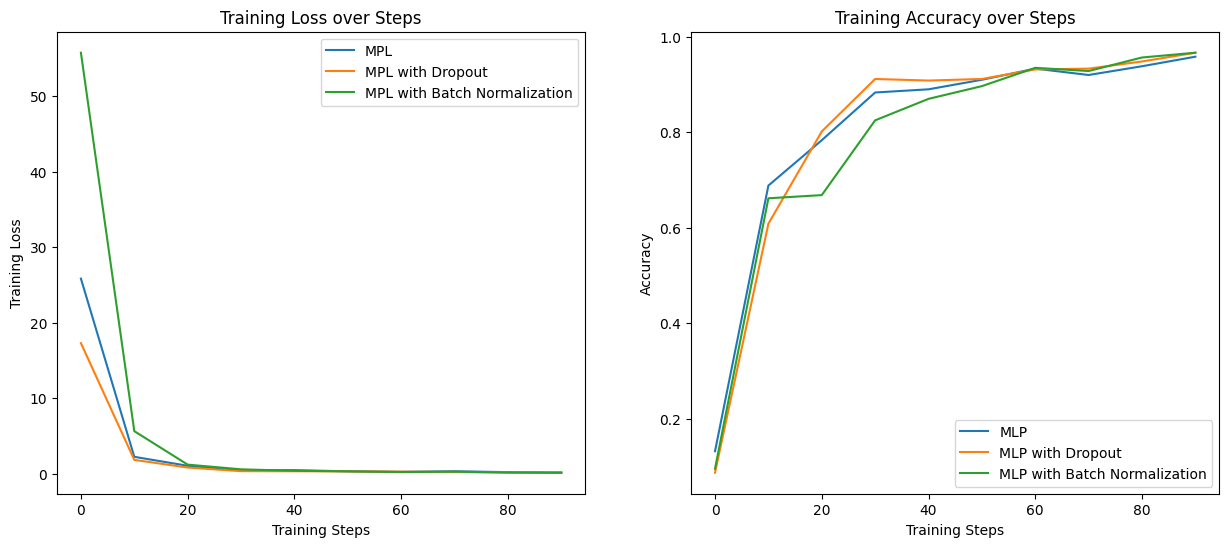

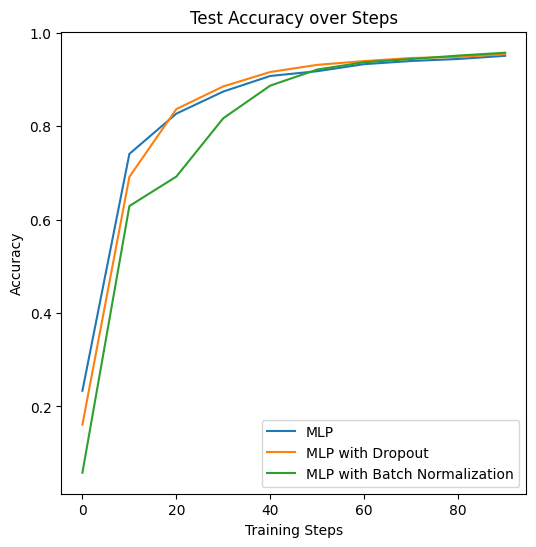

In [40]:
# Plot training loss and accuracy for MLP, MLP with dropout, and MLP with batch normalization
figure5 = plt.figure(figsize=(15, 6))
subplot = plot_training_loss_data(figure5, cnn_train_accuracy_x_axis, cnn_loss_data, cnn_dropout_loss_data, cnn_batch_norm_loss_data, 'Training Loss over Steps', "MPL", 1, 2, 1)
figure5.add_subplot(subplot)
subplot = plot_training_accuracy_data(figure5, cnn_train_accuracy_x_axis, cnn_train_accuracy, cnn_dropout_train_accuracy, cnn_batch_norm_train_accuracy, 'Training Accuracy over Steps', "MLP", 1, 2, 2)
figure5.add_subplot(subplot)
plt.show()

figure6 = plt.figure(figsize=(6, 6))
subplot = plot_test_accuracy_data(figure6, cnn_train_accuracy_x_axis, cnn_test_accuracy, cnn_dropout_test_accuracy, cnn_batch_norm_test_accuracy, 'Test Accuracy over Steps', "MLP", 1, 1, 1)
figure6.add_subplot(subplot)

plt.show()

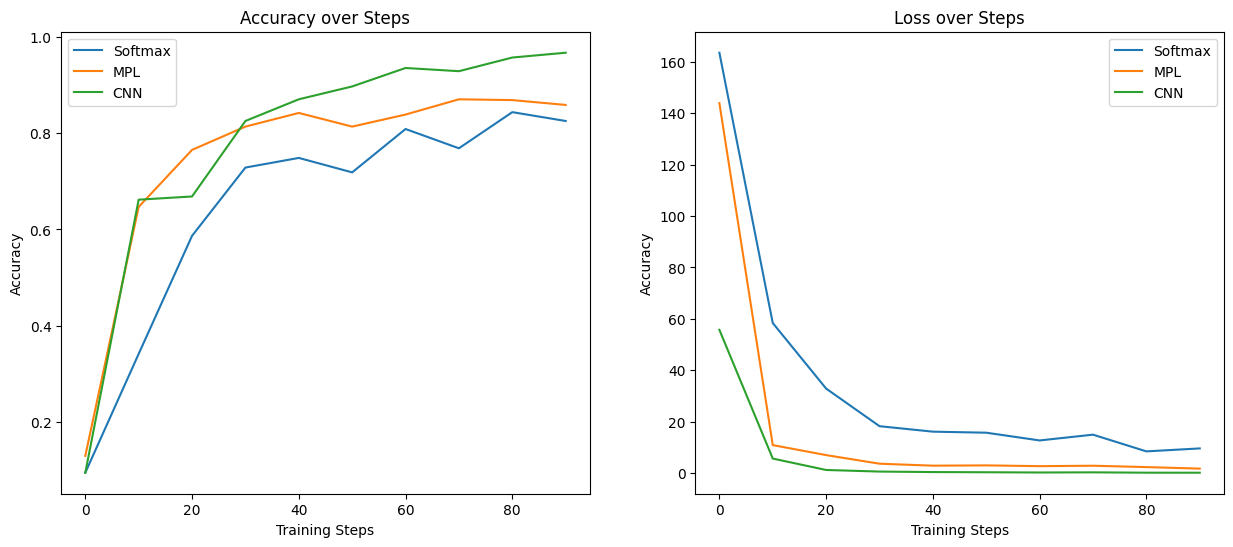

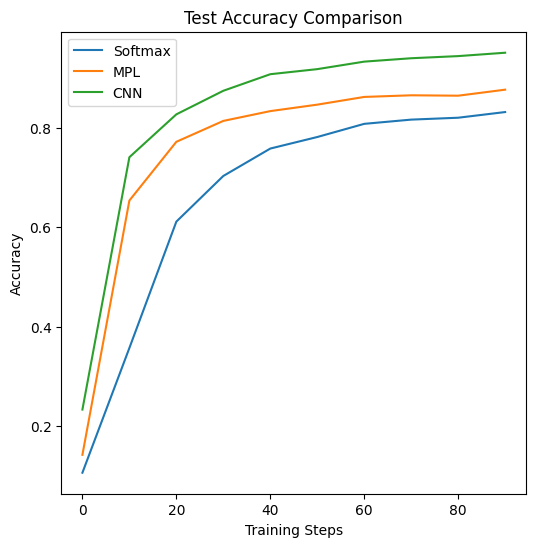

In [41]:
# Train Accuracy, Loss Comparison for all classifiers
figure7 = plt.figure(figsize=(15, 6))
subplot10 = compare_classifiers(figure7, cnn_train_accuracy_x_axis, softmax_train_accuracy, mlp_train_accuracy, cnn_batch_norm_train_accuracy, 'Accuracy over Steps', "Accuracy", 1, 2, 1)
figure7.add_subplot(subplot10)
subplot11 = compare_classifiers(figure7, cnn_train_accuracy_x_axis, softmax_loss_data, mlp_loss_data, cnn_batch_norm_loss_data, 'Loss over Steps', "Loss", 1, 2, 2)
figure7.add_subplot(subplot11)
plt.show()


# Test Accuracy Comparison for all classifiers
figure8 = plt.figure(figsize=(6, 6))
subplot = compare_classifiers(figure8, cnn_train_accuracy_x_axis, softmax.get_test_data_accuracy(), mlp_test_accuracy, cnn_test_accuracy, 'Test Accuracy Comparison', "Accuracy", 1, 1, 1)
figure8.add_subplot(subplot)
plt.show()